In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.tsa as tsa
import statsmodels as sm
from datetime import datetime
import os
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.metrics import mean_squared_error


2025-07-24 18:52:39.936155: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-24 18:52:40.338554: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753404760.483857  559850 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753404760.559801  559850 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-24 18:52:41.047772: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
sup_imp = pd.read_csv('./data/importacion.csv', parse_dates=['Fecha'], dayfirst=True)
sup_imp.set_index('Fecha', inplace=True)
sup_imp_h = sup_imp['Gasolina superior']

sup_imp_h.head()

Fecha
2001-01-01    373963.96
2001-01-02    243091.07
2001-01-03    312084.38
2001-01-04    285054.89
2001-01-05    300913.67
Name: Gasolina superior, dtype: float64

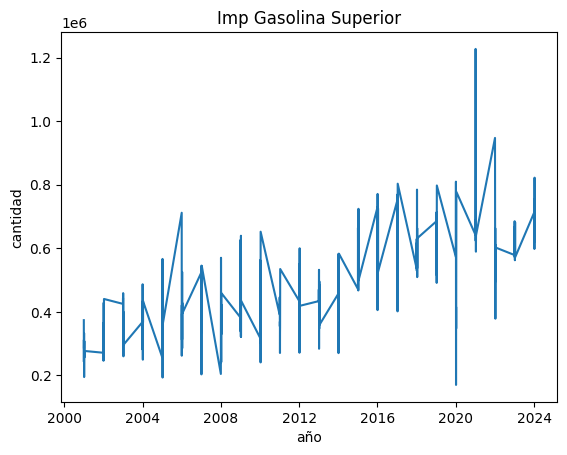

In [3]:
plt.plot(sup_imp_h)
plt.gca().set(title="Imp Gasolina Superior", ylabel="cantidad" , xlabel="año")
plt.show()

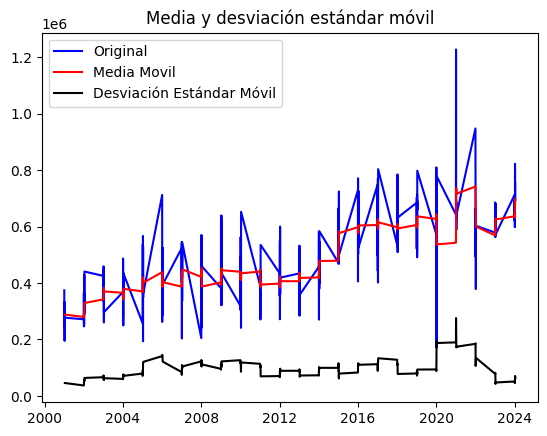

In [4]:
# Se calcula la media móvil y la desviación estandar móvil de los últimos 12 meses.
mediaMovil = sup_imp_h.rolling(window=12).mean()
deMovil = sup_imp_h.rolling(window=12).std()
# Se grafican los resultados.
original = plt.plot(sup_imp_h, color="blue", label="Original")
media = plt.plot(mediaMovil, color='red', label = 'Media Movil')
ds = plt.plot(deMovil,color='black', label = 'Desviación Estándar Móvil')
plt.legend(loc = 'best')
plt.title('Media y desviación estándar móvil')
plt.show(block=False)

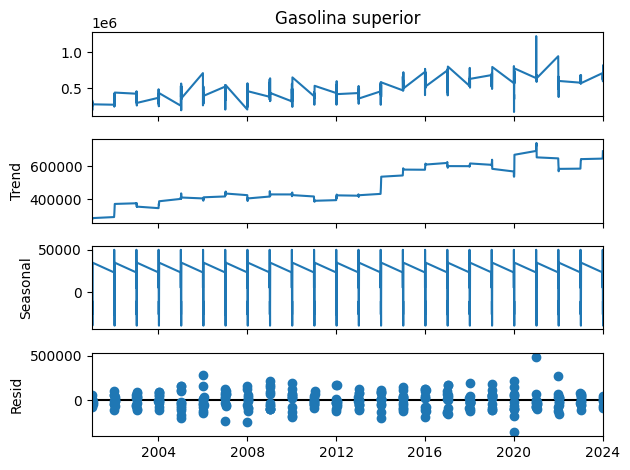

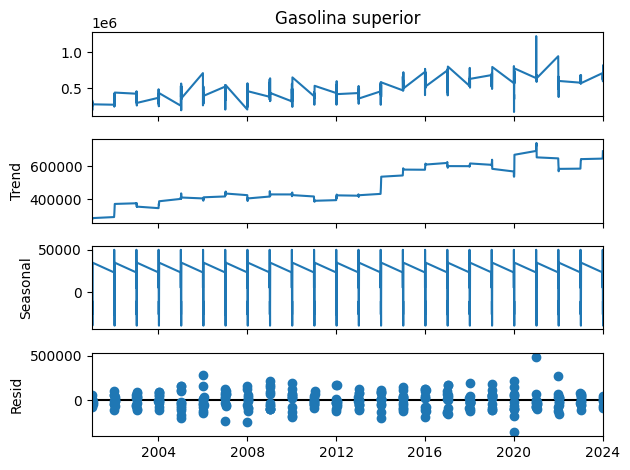

In [5]:
descomposicion = seasonal_decompose(sup_imp_h, period= 12)
descomposicion.plot()

In [6]:
print('Resultados del Test de Dickey Fuller')
dfTest = adfuller(sup_imp_h, autolag='AIC')
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller
Estadístico de prueba         -1.601987
p-value                        0.482595
# de retardos usados           9.000000
# de observaciones usadas    278.000000
Critical Value (1%)           -3.454094
Critical Value (5%)           -2.871993
Critical Value (10%)          -2.572340
dtype: float64


p-values es mayor a 0.05

In [7]:
print('Resultados del Test de Dickey Fuller para una diferenciación de la serie')
sup_imp_h_diff = sup_imp_h.diff()
sup_imp_h_diff.fillna(0,inplace=True)
dfTest = adfuller(sup_imp_h_diff)
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller para una diferenciación de la serie
Estadístico de prueba       -7.800177e+00
p-value                      7.529848e-12
# de retardos usados         1.100000e+01
# de observaciones usadas    2.760000e+02
Critical Value (1%)         -3.454267e+00
Critical Value (5%)         -2.872070e+00
Critical Value (10%)        -2.572381e+00
dtype: float64


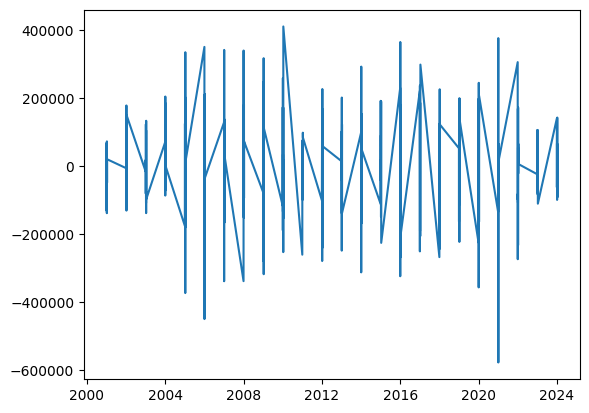

In [8]:
plt.plot(sup_imp_h_diff)

In [9]:
scaler = StandardScaler()
sup_imp_h_diff_scaled = scaler.fit_transform(sup_imp_h_diff.values.reshape(-1, 1))
sup_imp_h_diff_scaled[1:7]

array([[-0.84051577],
       [ 0.43027508],
       [-0.18025785],
       [ 0.09243469],
       [ 0.19699376],
       [-0.88675546]])

# Fase de Entrenamiento

In [10]:
total_len = len(sup_imp_h_diff_scaled)

# Definir proporciones
train_prop = 0.6
val_prop = 0.2
test_prop = 0.2 

# Calcular índices
train_end = int(train_prop * total_len)
val_end = train_end + int(val_prop * total_len)

# Separar sin solapamientos
train = sup_imp_h_diff_scaled[:train_end]
validation = sup_imp_h_diff_scaled[train_end:val_end]
test = sup_imp_h_diff_scaled[val_end:]

# Si hace falta, redimensionar (por ejemplo para un LSTM univariante)
train = train.reshape(-1, 1)
validation = validation.reshape(-1, 1)
test = test.reshape(-1, 1)

# Verificar tamaños
print(f"Total registros: {total_len}")
print(f"Train: {len(train)} | Validation: {len(validation)} | Test: {len(test)}")

Total registros: 288
Train: 172 | Validation: 57 | Test: 59


In [11]:
train, type(train)

(array([[-0.00839873],
        [-0.84051577],
        [ 0.43027508],
        [-0.18025785],
        [ 0.09243469],
        [ 0.19699376],
        [-0.88675546],
        [ 0.456268  ],
        [ 0.24774682],
        [-0.02961474],
        [-0.31654349],
        [ 0.12198815],
        [-0.04442466],
        [ 0.59040934],
        [-0.76734717],
        [ 0.39829577],
        [ 0.32893891],
        [-0.72807519],
        [ 1.1279377 ],
        [-0.83854206],
        [ 0.19998117],
        [ 0.12513508],
        [-0.39540212],
        [ 0.94208373],
        [-0.10690206],
        [ 0.11027309],
        [-0.5202166 ],
        [-0.18584341],
        [ 0.77735496],
        [-0.5586327 ],
        [ 0.17240607],
        [-0.69863262],
        [ 0.6644721 ],
        [-0.88565492],
        [ 0.84189738],
        [-0.6262373 ],
        [ 0.44592695],
        [-0.55738656],
        [ 1.29496299],
        [-0.46272333],
        [-0.42405417],
        [-0.25519219],
        [-0.39960224],
        [ 1

In [12]:
from operator import concat


def supervisada(serie,retrasos = 1):
    serie_x = []
    serie_y = []
    for i in range(len(serie)-retrasos):
        valor = serie[i:(i+retrasos),0]
        valor_sig = serie[i+retrasos,0]
        serie_x.append(valor)
        serie_y.append(valor_sig)
    return np.array(serie_x), np.array(serie_y)

x_train,y_train = supervisada(train)
x_val,y_val = supervisada(validation)
x_test,y_test = supervisada(test)



In [13]:
x_train

array([[-0.00839873],
       [-0.84051577],
       [ 0.43027508],
       [-0.18025785],
       [ 0.09243469],
       [ 0.19699376],
       [-0.88675546],
       [ 0.456268  ],
       [ 0.24774682],
       [-0.02961474],
       [-0.31654349],
       [ 0.12198815],
       [-0.04442466],
       [ 0.59040934],
       [-0.76734717],
       [ 0.39829577],
       [ 0.32893891],
       [-0.72807519],
       [ 1.1279377 ],
       [-0.83854206],
       [ 0.19998117],
       [ 0.12513508],
       [-0.39540212],
       [ 0.94208373],
       [-0.10690206],
       [ 0.11027309],
       [-0.5202166 ],
       [-0.18584341],
       [ 0.77735496],
       [-0.5586327 ],
       [ 0.17240607],
       [-0.69863262],
       [ 0.6644721 ],
       [-0.88565492],
       [ 0.84189738],
       [-0.6262373 ],
       [ 0.44592695],
       [-0.55738656],
       [ 1.29496299],
       [-0.46272333],
       [-0.42405417],
       [-0.25519219],
       [-0.39960224],
       [ 1.16702684],
       [-0.09759059],
       [-0

In [14]:

y_train, type(y_train)

(array([-0.84051577,  0.43027508, -0.18025785,  0.09243469,  0.19699376,
        -0.88675546,  0.456268  ,  0.24774682, -0.02961474, -0.31654349,
         0.12198815, -0.04442466,  0.59040934, -0.76734717,  0.39829577,
         0.32893891, -0.72807519,  1.1279377 , -0.83854206,  0.19998117,
         0.12513508, -0.39540212,  0.94208373, -0.10690206,  0.11027309,
        -0.5202166 , -0.18584341,  0.77735496, -0.5586327 ,  0.17240607,
        -0.69863262,  0.6644721 , -0.88565492,  0.84189738, -0.6262373 ,
         0.44592695, -0.55738656,  1.29496299, -0.46272333, -0.42405417,
        -0.25519219, -0.39960224,  1.16702684, -0.09759059, -0.34960554,
         0.42284443, -0.01832377, -1.12287794,  0.30183349,  0.7879504 ,
         0.64168988, -0.99732584,  1.00117106, -1.11464762,  1.28363775,
        -2.3808626 ,  2.12409708, -1.15407963,  0.0686576 ,  2.22367412,
        -2.86762041,  0.91922845,  0.0757552 , -0.70319902,  0.51291169,
        -0.12325143, -0.40657705,  1.34142522, -1.5

# Creando el modelo

In [15]:
(x_train.shape[0],1,1)

(171, 1, 1)

In [16]:
x_train = np.reshape(x_train,(x_train.shape[0],1,1))
x_val = np.reshape(x_val, (x_val.shape[0],1,1))
x_test = np.reshape(x_test, (x_test.shape[0],1,1))
len(x_val)

56

In [17]:
unidades =  10
paso = 1 # lags, 1 lag es un mes. 
caracteristicas = 1 # es univariada
lote = 1


modelo1 = Sequential()
modelo1.add(LSTM(
    units=unidades, 
    input_shape=(paso, caracteristicas), 
    stateful=False  # desactivamos estado entre batches
))

modelo1.add(Dense(1))
modelo1.summary()

2025-07-24 18:52:45.835658: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/home/bianca_cal/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10)             │           480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 491 (1.92 KB)

 Trainable params: 491 (1.92 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
modelo1.compile(loss='mean_squared_error',optimizer="rmsprop")

In [19]:
epocas = 50
history= modelo1.fit(
    x = x_train,
    y = y_train,
    batch_size = lote,
    epochs = epocas,
    shuffle = False,
    validation_data = (x_val,y_val),
    verbose=1
)

Epoch 1/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6351 - val_loss: 0.9323
Epoch 2/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5302 - val_loss: 0.7509
Epoch 3/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4550 - val_loss: 0.6312
Epoch 4/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4135 - val_loss: 0.5702
Epoch 5/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3968 - val_loss: 0.5440
Epoch 6/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3918 - val_loss: 0.5331
Epoch 7/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3907 - val_loss: 0.5284
Epoch 8/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3906 - val_loss: 0.5260
Epoch 9/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3907 - val_loss: 0.5248
Epoch 10/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3908 - val_loss: 0.5240
Epoch 11/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3908 - val_loss: 0.5234
Epoch 12/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

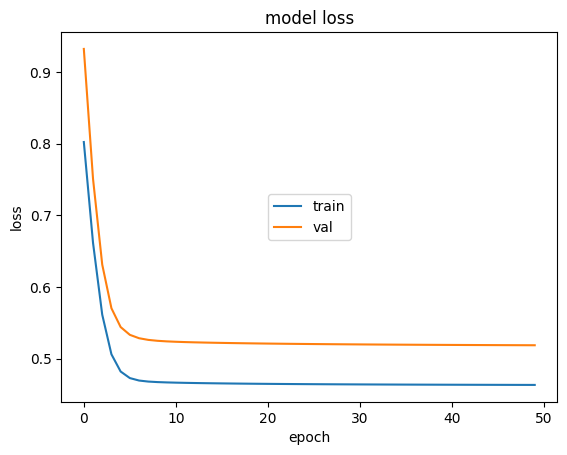

In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='center')

In [21]:
print("Pérdida en Train")
modelo1.evaluate(
    x = x_train,
    y = y_train
)
print("Pérdida en Validación")
modelo1.evaluate(
    x = x_val,
    y = y_val
)
print("Pérdida en Test")
modelo1.evaluate(
    x = x_test,
    y = y_test
)

Pérdida en Train
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4221  
Pérdida en Validación
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.5495
Pérdida en Test
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.1441


0.9427313208580017

In [22]:
prediccion_val = []

def prediccion_fun(data,modelo, batch_size,scaler,dif=False,dif_cant=1, Series = None , n=1):
    prediccion = [0]* (len(data))
    i=0
    for X in data:
        # X = np.reshape(X,(1,1,1))
        X = np.reshape(X, (1,) + X.shape)
        yhat = modelo1.predict(X, batch_size=batch_size,verbose=0)
        # invert scaling
        yhat = scaler.inverse_transform(yhat)
        if dif:
             # invert differencing
            yhat  = yhat + Series[(n+dif_cant*i)]
        # store
        prediccion[i]=yhat[0][0]
        i = i+1
    return prediccion


prediccion_val = prediccion_fun(x_val,modelo1, 1,scaler,dif=True,dif_cant=1, Series = sup_imp_h.values , n=train_end)
prediccion_test = prediccion_fun(x_test,modelo1, 1,scaler,dif=True,dif_cant=1, Series = sup_imp_h.values , n = len(sup_imp_h.values) - len(x_test))


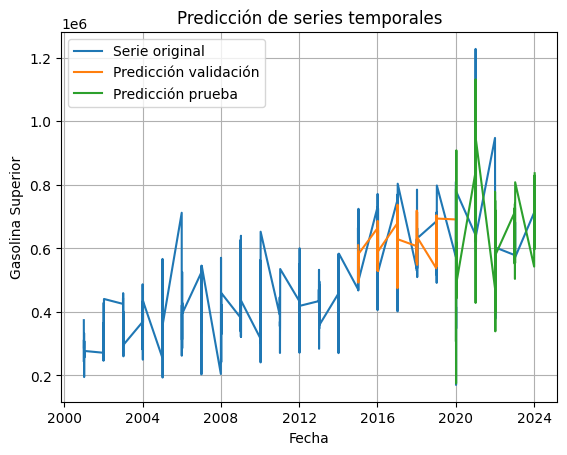

In [23]:
# df_val = pd.DataFrame(prediccion_val,index=airPas[(train_prop):train_prop+val_prop].index) 
# df_test = pd.DataFrame(prediccion_test,index=airPas[train_prop+len(df_val):len(airPas)].index)
df_val = pd.DataFrame(prediccion_val, index=sup_imp_h[train_end+1:val_end].index)
df_test = pd.DataFrame(prediccion_test, index=sup_imp_h[val_end:].index[:len(prediccion_test)])


plt.plot(sup_imp_h, label='Serie original')
plt.plot(df_val, label='Predicción validación')
plt.plot(df_test, label='Predicción prueba')

plt.legend()
plt.title('Predicción de series temporales')
plt.xlabel('Fecha')
plt.ylabel('Gasolina Superior')
plt.grid(True)
plt.show()



# Segundo Modelo

In [24]:
unidades =  32 #aumentamos
paso = 3 # lags, 1 lag es un mes. 
caracteristicas = 1 # es univariada
lote = 1


modelo2 = Sequential()
modelo2.add(LSTM(
    units=unidades, 
    input_shape=(paso, caracteristicas), 
    stateful=False  # desactivamos estado entre batches
))

modelo2.add(Dense(1))
modelo2.summary()

/home/bianca_cal/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 32)             │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,385 (17.13 KB)

 Trainable params: 4,385 (17.13 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
modelo2.compile(loss='mean_squared_error',optimizer="adam")